In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal, stats
from scipy.fft import rfft, fftfreq
from uncertainties import ufloat
import uncertainties.umath as un 
import os
import re
from sklearn.linear_model import LinearRegression

plt.style.use('me310.mplstyle')
data_path = './data/'
save_path = './plots/'

f_n = 75.008 Hz


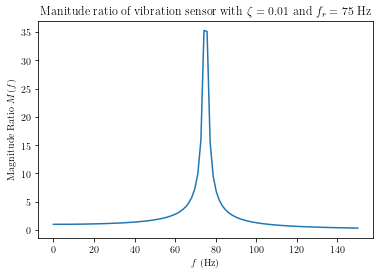

In [2]:
## PRELAB ##
f_r = 75 # Hz
damping = 0.01
f_max = 2 * f_r

def f_natural(f_r, damping):
    top = f_r
    bottom = np.sqrt(1 - 2 * damping ** 2)
    return top/bottom
f_n = f_natural(f_r, damping)
print(f'f_n = {f_n:.3f} Hz')

def mag_ratio(omega, omega_n, damping):
    ratio = omega/omega_n
    denom1 = (1 - ratio ** 2) ** 2
    denom2 = (2 * damping * ratio) ** 2
    denom_tot = np.sqrt(denom1 + denom2)
    return 1/denom_tot

f_inputs = np.linspace(0, f_max, 100)
fig1, ax1 = plt.subplots(figsize=(6,4))
ax1.plot(f_inputs, mag_ratio(f_inputs, f_n, damping))
ax1.set_xlabel('$f$ (Hz)')
ax1.set_ylabel('Magnitude Ratio $M(f)$')
ax1.set_title('Manitude ratio of vibration sensor with $\zeta = 0.01$ and $f_r = 75$ Hz')
fig1.savefig(save_path + 'mag_ratio_plt.pdf', bbox_inches = 'tight')
plt.show()

In [3]:
## INLAB ##
datafiles = os.listdir(data_path)
sensor_data = pd.DataFrame
ruler_data = {}
datafiles.sort()
for file in datafiles:
    f_ruler = re.search('ruler_(\d*)in_trial(\d*).csv', file)
    f_raw = re.search('raw_(\d*)in.csv', file)
    if f_ruler:
        ruler_l = float(f_ruler.group(1))
        df = pd.read_csv(data_path + file, header=1, names=['time','volt'])
        if ruler_l not in ruler_data:
            ruler_data[ruler_l] = []
        ruler_data[ruler_l].append(df)
    if f_raw:
        ruler_l = float(f_raw.group(1))
        df = pd.read_csv(data_path + file, header=1, names=['time','volt'])
        sensor_data = df

In [4]:
## UNCERTANTIES ##
t_interval = 3.340000112075359e-04 # s
u_time = 0.5 * t_interval # s
u_mass = 0.5 * 1e-3 # kg
u_ruler_l = 0.5 * 0.003175 # m
u_ruler_w = 0.5 * 1e-5 # m
u_ruler_h = 0.5 * 1e-5 # m
u_linearity_sensor = 5 * 0.01 # V
u_linearity_scope = 5 * 0.03 + 200e-6 # V

scope_bits = 8
v_res_scope = 10 / (2**scope_bits) # V
u_v_scope = 0.5 * v_res_scope # V
max_freq = 1 / (t_interval * 2) # Hz
print(f'max_freq = {max_freq}')

max_freq = 1497.0059377911741


u_t_d_rand = 0.0007758621722186755 s
t_d = 0.0117+/-0.0009 s
f_d = 86+/-7 Hz
w_d = (5.4+/-0.4)e+02 rad/s
u_points = [0.01082273 0.02441575 0.05389644 0.11633007 0.22478091 0.51056888]
u_lin_reg_linearity = 0.534
u_lin_reg_v_scope = 0.208
u_y_sensor = 0.122
u_yx_sensor = 0.044
u_y_tot = 0.586
u_alpha = 12.068 Hz
alpha = -66+/-12 Hz
f_n = 86+/-7 Hz
w_n = (5.4+/-0.4)e+02 rad/s
sensor_damping = 0.121+/-0.024
f_r = 85+/-7 Hz
w_r = (5.3+/-0.4)e+02 rad/s


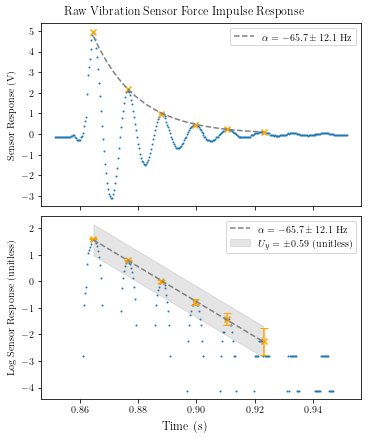

In [86]:
## SENSOR PARAMS ##

fig2, ax2 = plt.subplots(2, 1, figsize=(5,6), constrained_layout=True, sharex=True)
step_resp = sensor_data.iloc[2550:2850]

step_resp_time = step_resp.time.to_numpy()
step_resp_volt = step_resp.volt.to_numpy()

ax2[0].scatter(step_resp_time, step_resp_volt, s=1)

log_step_resp_ind = np.argwhere(step_resp_volt>0)
log_step_resp_volt = np.log(step_resp_volt[log_step_resp_ind])
log_step_resp_time = step_resp_time[log_step_resp_ind]

ax2[1].scatter(log_step_resp_time, log_step_resp_volt, s=1)

peaks, _ = signal.find_peaks(step_resp_volt, height=0.1, distance=10)
peak_time = step_resp_time[peaks]
peak_volt = step_resp_volt[peaks]
ax2[0].scatter(peak_time, peak_volt, marker='x', c='orange')

t_d_diffs = np.diff(peak_time)
std_dev_t_d = np.std(t_d_diffs, ddof=1)
u_t_d_rand = stats.t.ppf(0.975, len(t_d_diffs) - 1) * std_dev_t_d / np.sqrt(t_d_diffs.shape[0])
print(f'u_t_d_rand = {u_t_d_rand} s')
t_d = ufloat(np.mean(np.diff(peak_time)), u_time + u_t_d_rand)

f_d = 1 / t_d
w_d = 2 * np.pi * f_d
print(f't_d = {t_d} s')
print(f'f_d = {f_d} Hz')
print(f'w_d = {w_d} rad/s')

log_peak = np.log(peak_volt)
xvals = peak_time.reshape(-1,1)
yvals = log_peak.reshape(-1,1)
reg = LinearRegression().fit(xvals, yvals)

## SENOR_UNCERTAINTY ##
t_val = stats.t.ppf(0.975, len(peaks) - 2)
log_peak_predicted = reg.predict(peak_time.reshape(-1,1)).flatten()

u_yx_sensor = np.sqrt(np.sum((log_peak - log_peak_predicted) ** 2) / (len(peaks) - 2))
u_y_sensor = t_val * u_yx_sensor

y_err = np.sqrt((1/peak_volt * u_linearity_sensor) ** 2 + (1/peak_volt * u_v_scope) ** 2)
ax2[1].errorbar(peak_time, np.log(peak_volt), yerr=y_err, c='orange', fmt='none')
ax2[1].scatter(peak_time, np.log(peak_volt), marker='x', c='orange')
print(f'u_points = {y_err}')
u_lin_reg_linearity = np.sqrt(np.sum((1/peak_volt * u_linearity_sensor) ** 2))
u_lin_reg_v_scope = np.sqrt(np.sum((1/peak_volt * u_v_scope) ** 2))
print(f'u_lin_reg_linearity = {u_lin_reg_linearity:.3f}')
print(f'u_lin_reg_v_scope = {u_lin_reg_v_scope:.3f}')
u_y_tot = np.sqrt(u_y_sensor ** 2 + u_lin_reg_linearity ** 2 + u_lin_reg_v_scope ** 2)
mean_time = np.mean(peak_time)
print(f'u_y_sensor = {u_y_sensor:.3f}')
print(f'u_yx_sensor = {u_yx_sensor:.3f}')
print(f'u_y_tot = {u_y_tot:.3f}')
u_alpha = u_y_tot / np.sqrt(np.sum((peak_time - mean_time) ** 2))
print(f'u_alpha = {u_alpha:.3f} Hz')

alpha = ufloat(reg.coef_.flatten()[0], u_alpha)

print(f'alpha = {alpha} Hz')
w_n = un.sqrt(w_d ** 2 + alpha ** 2)
f_n = w_n / (2 * np.pi)
print(f'f_n = {f_n} Hz')
print(f'w_n = {w_n} rad/s')
sensor_damping = np.abs(alpha/w_n)
print(f'sensor_damping = {sensor_damping}')
w_r = w_n * un.sqrt(1 - 2 * sensor_damping ** 2)
f_r = w_r / (2 * np.pi)
print(f'f_r = {f_r} Hz')
print(f'w_r = {w_r} rad/s')

reg_time = step_resp_time[peaks[0]:peaks[-1]]

def u_bound(xvals, fit, uncertainty):
    xvals = np.array(xvals)
    yvals = np.ravel(fit.predict(xvals.reshape(-1,1)))
    yvals += uncertainty
    return yvals

hbound = u_bound(reg_time, reg, u_y_tot)
lbound = u_bound(reg_time, reg, -u_y_tot)
ax2[1].fill_between(reg_time, hbound, lbound, color='grey', alpha=0.2,label=f'$U_y = \pm {u_y_tot:.2f}$ (unitless)')
ax2[0].plot(reg_time, np.exp(reg.predict(reg_time.reshape(-1,1))), c='grey', ls='--', label=f'$\\alpha = {alpha.n:.1f} \pm {alpha.s:.1f}$ Hz')
ax2[1].plot(reg_time, reg.predict(reg_time.reshape(-1,1)), c='grey', ls='--', label=f'$\\alpha = {alpha.n:.1f} \pm {alpha.s:.1f}$ Hz')
fig2.supxlabel('Time (s)')
ax2[0].set_ylabel('Sensor Response (V)')
ax2[1].set_ylabel('Log Sensor Response (unitless)')
fig2.suptitle('Raw Vibration Sensor Force Impulse Response')
ax2[0].legend()
ax2[1].legend()
fig2.savefig(save_path + 'sensor_response.pdf', bbox_inches = 'tight')
plt.show()

In [6]:
## RULER DENSITY ##
l_dim = ufloat(0.9144, u_ruler_l) # m
print(f'l_dim = {l_dim} m')
w_dim = ufloat(0.0287, u_ruler_w) # m
print(f'w_dim = {w_dim} m')
h_dim = ufloat(0.0057, u_ruler_h) # m
print(f'h_dim = {h_dim} m')
v_ruler = l_dim * w_dim * h_dim # m^3
print(f'v_ruler = {v_ruler} m')
m_ruler = ufloat(0.081, u_mass) # kg
print(f'm_ruler = {m_ruler} m')
rho_ruler = m_ruler/v_ruler
print(f'rho_ruler = {rho_ruler:.3f} kg/m^3')

l_dim = 0.9144+/-0.0016 m
w_dim = 0.028700+/-0.000005 m
h_dim = 0.005700+/-0.000005 m
v_ruler = 0.00014959+/-0.00000029 m
m_ruler = 0.0810+/-0.0005 m
rho_ruler = 541.492+/-3.506 kg/m^3


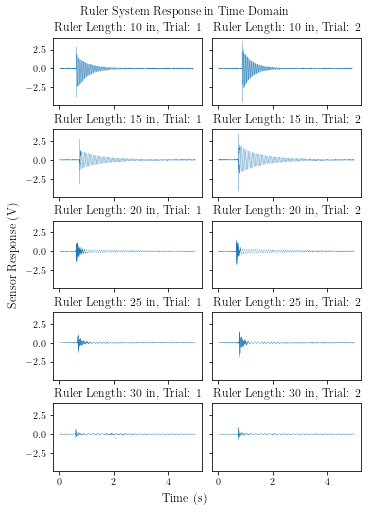

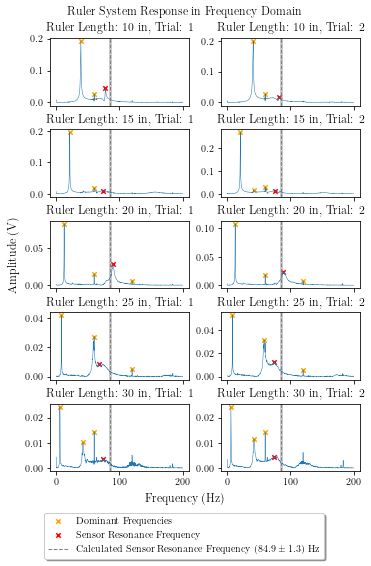

In [7]:
## FFT Analysis ##
'''databounds = {10: [np.arange(0,10000), np.arange(0,10000)],
15: [np.arange(0,10000), np.arange(0,10000)],
20: [np.arange(0,10000), np.arange(0,10000)],
25: [np.arange(0,10000), np.arange(0,10000)],
30: [np.arange(0,10000), np.arange(0,10000)]}'''

fft_results = {}
sensor_results = {}
f_n_results = {}

max_plot_freq = 400 # Hz
peak_args = {10: [0.01, 40, 0.01], 
15: [0.008, 40, 0.0075], 
20: [0.005, 40, 0.001], 
25: [0.005, 40, 0.001], 
30: [0.002, 40, 0.001]}

fig3, ax3 = plt.subplots(len(ruler_data), 2, figsize=(5,7), sharex=True, sharey=True, constrained_layout=True)
fig4, ax4 = plt.subplots(len(ruler_data), 2, figsize=(5,7), sharex=True, sharey=False, constrained_layout=True)

for i, (ruler_length, trials) in enumerate(ruler_data.items()):
    fft_trial_results = []
    sensor_trial_results = []
    f_n_trial_results = []
    for trial_num, data in enumerate(trials):
        data.plot(x='time', y='volt', ax=ax3[i, trial_num], lw=0.2, legend=False)
        ax3[i, trial_num].set_title(f'Ruler Length: {ruler_length:.0f} in, Trial: {trial_num + 1}')
        ax3[i, trial_num].set_xlabel(None)
        ax3[i, trial_num].set_ylabel(None)

        t_interval = np.mean(np.diff(data.time))
        num_samples = data.shape[0]
        fft_res = rfft(data.volt.to_numpy())
        fft_res = 2.0/num_samples * np.abs(fft_res[0:num_samples//2]) # 2 = nyquist
        fft_freq = fftfreq(num_samples, t_interval)[0:num_samples//2]


        fft_plot_ind = np.argwhere(fft_freq <= 200)
        fft_res = fft_res[fft_plot_ind].flatten()
        fft_freq = fft_freq[fft_plot_ind].flatten()

        ax4[i, trial_num].plot(fft_freq, fft_res, lw=0.5)
        ax4[i, trial_num].set_title(f'Ruler Length: {ruler_length:.0f} in, Trial: {trial_num + 1}')
        fft_peaks, _ = signal.find_peaks(fft_res, height=peak_args[ruler_length][0], distance=peak_args[ruler_length][1], prominence=peak_args[ruler_length][2])
        peak_freq = fft_freq[fft_peaks]
        peak_amp = fft_res[fft_peaks]

        peak_freq = peak_freq[:4] # 4 frequencies including sensor resonance
        peak_amp = peak_amp[:4]

        freq_diff = np.abs(peak_freq - f_r)
        freq_index = np.argmin(freq_diff)
        f_r_exp = peak_freq[freq_index]
        amp_r_exp = peak_amp[freq_index]

        zipped_sensor = np.column_stack((f_r_exp, amp_r_exp))
        sensor_trial_results.append(zipped_sensor)

        zipped_fft = np.column_stack((peak_freq, peak_amp))
        fft_trial_results.append(zipped_fft)

        n_f_no_sensor = peak_freq[np.arange(len(peak_freq))!=freq_index]
        peak_amp_no_sensor = peak_amp[np.arange(len(peak_amp))!=freq_index]

        zipped_no_sensor = np.column_stack((n_f_no_sensor, peak_amp_no_sensor))
        f_n_trial_results.append(zipped_no_sensor)

        dom_freq_scat = ax4[i, trial_num].scatter(n_f_no_sensor, peak_amp_no_sensor, marker='x', s=20, c='orange')
        f_r_scat = ax4[i, trial_num].scatter(f_r_exp, amp_r_exp, marker='x', s=20, c='red')
        f_r_th = ax4[i, trial_num].axvline(x=f_r.n, ls='--', c='grey', lw=1)
        ax4[i, trial_num].axvspan(f_r.n - f_r.s, f_r.n + f_r.s, alpha=0.3, color='grey')

    fft_results[ruler_length] = fft_trial_results
    sensor_results[ruler_length] = sensor_trial_results
    f_n_results[ruler_length] =f_n_trial_results

fig3.supxlabel('Time (s)')
fig3.supylabel('Sensor Response (V)')
fig3.suptitle('Ruler System Response in Time Domain')
fig3.savefig(save_path + 'ruler_response.pdf', bbox_inches = 'tight')

fig4.supxlabel('Frequency (Hz)')
fig4.supylabel('Amplitude (V)')
fig4.suptitle('Ruler System Response in Frequency Domain')
fig4.legend((dom_freq_scat, f_r_scat, f_r_th), ('Dominant Frequencies', 'Sensor Resonance Frequency', 
f'Calculated Sensor Resonance Frequency $({f_r.n:.1f} \pm {f_r.s:.1f})$ Hz'), loc='upper center', bbox_to_anchor=(0.5, 0), fancybox=True, ncol=1, shadow=True)

fig4.savefig(save_path + 'ruler_response_frequency.pdf', bbox_inches = 'tight')

plt.show()

In [65]:
def pretty_print_stats(data_dict, unitx, unity, altunitx='Freq (rads/s)'):
    for l, trials in data_dict.items():
        print(f'Ruler Length: {l:.0f}')
        for i, trial in enumerate(trials):
            print(f'Trial {i + 1}:')
            print(unitx + '\t' + altunitx + '\t' + unity)
            with np.printoptions(suppress=True, precision=None):
                try:
                    toprint = np.insert(trial, 1, trial[:,0] * 2 * np.pi, axis=1)
                except:
                    toprint = np.insert(trial, 1, trial[0] * 2 * np.pi)
                print(np.array2string(toprint, separator='\t'))
    print()

print('FFT_RESULTS:')
pretty_print_stats(fft_results, 'Freq (Hz)', 'Amp (V)')
print('SENSOR_RESULTS:')
pretty_print_stats(sensor_results, 'Freq (Hz)', 'Amp (V)')
print('NATURAL_FREQUENCIES:')
pretty_print_stats(f_n_results, 'Freq (Hz)', 'Amp (V)')

FFT_RESULTS:
Ruler Length: 10
Trial 1:
Freq (Hz)	Freq (rads/s)	Amp (V)
[[ 38.98082861	244.9237696 	  0.19284031]
 [ 60.09544411	377.59081147	  0.02507767]
 [ 77.96165723	489.84753921	  0.04602685]]
Trial 2:
Freq (Hz)	Freq (rads/s)	Amp (V)
[[ 41.2029293 	258.88564002	  0.20019255]
 [ 60.07914815	377.48842091	  0.02768351]
 [ 82.40585861	517.77128003	  0.01836453]]
Ruler Length: 15
Trial 1:
Freq (Hz)	Freq (rads/s)	Amp (V)
[[ 21.3929396 	134.41580379	  0.19539311]
 [ 59.98020449	376.86673959	  0.01936932]
 [ 73.77565153	463.5460897 	  0.00981456]]
Trial 2:
Freq (Hz)	Freq (rads/s)	Amp (V)
[[ 20.99307157	131.90335886	  0.2690682 ]
 [ 41.78620913	262.55049525	  0.01630321]
 [ 59.98020449	376.86673959	  0.02994905]
 [ 74.7753216 	469.82720203	  0.01300027]]
Ruler Length: 20
Trial 1:
Freq (Hz)	Freq (rads/s)	Amp (V)
[[ 12.59584294	 79.14201531	  0.08336023]
 [ 59.98020449	376.86673959	  0.01474567]
 [ 89.77037272	564.04388692	  0.02851279]
 [119.96040899	753.73347918	  0.00615834]]
Trial 2:
Fre

In [66]:
mode_coeffs = np.array([1.8752 ** 2, 4.6942 ** 2, 7.8552 ** 2])
c_results = {}
f_fundamental_results = {}
for ruler_length, trials in f_n_results.items():
    c_trial_results = []
    f_fundamental_trial_results = []
    for i, trial in enumerate(trials):
        f_fundamental_trial_results.append(trial[0])
        trial_freqs = trial[:mode_coeffs.size,0]
        c_vals = trial_freqs / mode_coeffs[:trial_freqs.shape[0]]
        zipped_c = np.column_stack((trial_freqs, c_vals))
        c_trial_results.append(zipped_c)
    c_results[ruler_length] = c_trial_results
    f_fundamental_results[ruler_length] = f_fundamental_trial_results
print('CONSTANTS:')
pretty_print_stats(c_results, 'Freq (Hz)', 'C')
print('FUNDAMENTAL_FREQUENCIES:')
pretty_print_stats(f_fundamental_results, 'Freq (Hz)', 'Amp (V)')

CONSTANTS:
Ruler Length: 10
Trial 1:
Freq (Hz)	Freq (rads/s)	C
[[ 38.98082861	244.9237696 	 11.0855151 ]
 [ 60.09544411	377.59081147	  2.72720868]]
Trial 2:
Freq (Hz)	Freq (rads/s)	C
[[ 41.2029293 	258.88564002	 11.71744448]
 [ 60.07914815	377.48842091	  2.72646915]]
Ruler Length: 15
Trial 1:
Freq (Hz)	Freq (rads/s)	C
[[ 21.3929396 	134.41580379	  6.08380487]
 [ 59.98020449	376.86673959	  2.72197896]]
Trial 2:
Freq (Hz)	Freq (rads/s)	C
[[ 20.99307157	131.90335886	  5.97008889]
 [ 41.78620913	262.55049525	  1.89631201]
 [ 59.98020449	376.86673959	  0.97206084]]
Ruler Length: 20
Trial 1:
Freq (Hz)	Freq (rads/s)	C
[[ 12.59584294	 79.14201531	  3.58205334]
 [ 59.98020449	376.86673959	  2.72197896]
 [119.96040899	753.73347918	  1.94412168]]
Trial 2:
Freq (Hz)	Freq (rads/s)	C
[[ 12.59584294	 79.14201531	  3.58205334]
 [ 59.98020449	376.86673959	  2.72197896]
 [119.96040899	753.73347918	  1.94412168]]
Ruler Length: 25
Trial 1:
Freq (Hz)	Freq (rads/s)	C
[[  8.19729461	 51.50512108	  2.33117757

In [10]:
mom_inertia = w_dim * h_dim ** 3 / 12
print(f'mom_intertia: {mom_inertia} m^4')

mom_intertia: (4.429+/-0.012)e-10 m^4


In [84]:
def calc_e(const, mass, length, mom_inertia):
    res = ((const * 2 * np.pi) ** 2) * mass * (length ** 3) / mom_inertia
    return res

def pretty_print_stats_un(data_dict, unitx, unity):
    for l, trials in data_dict.items():
        print(f'Ruler Length: {l:.0f}')
        for i, trial in enumerate(trials):
            print(f'Trial {i + 1}:')
            print(unitx + '\t' + unity)
            for data in trial:
                for d in data:
                   print(d, end='\t')
                print()
            print()

e_results = {}
mass_extra = ufloat(13e-3, u_mass) # kg
all_e_results = []

for ruler_length, trials in c_results.items():
    e_trial_results = []
    for i, trial in enumerate(trials):
        trial_freqs = trial[:,0]
        c_vals = trial[:,1]
        ruler_l_m = ruler_length / 39.37 # convert in to m
        mass = rho_ruler * ruler_l_m * w_dim * h_dim + mass_extra
        print(f'Length {ruler_length} in, Trial {i} mass = {mass} kg')
        e_vals = calc_e(c_vals, mass, ruler_l_m, mom_inertia) / 1e09
        if ruler_length != 10.0: # ignore 10 inch length dataset
            all_e_results = np.append(all_e_results, e_vals)
        zipped_e = np.column_stack((trial_freqs, e_vals))
        e_trial_results.append(zipped_e)
    e_results[ruler_length] = e_trial_results

mean_e = np.mean(all_e_results)
stdev_e = np.std([r.n for r in all_e_results], ddof=1)
t_val = stats.t.ppf(0.975, len(all_e_results) - 1)
u_rand_e = t_val * stdev_e / np.sqrt(all_e_results.shape[0])
print(f'u_rand_e: {u_rand_e:.1f} GPa')
mean_e += ufloat(0, u_rand_e)
pretty_print_stats_un(e_results, 'Freq (Hz)', 'E (GPa)')
print(f'E = {mean_e} GPa')

Length 10.0 in, Trial 0 mass = 0.0355+/-0.0005 kg
Length 10.0 in, Trial 1 mass = 0.0355+/-0.0005 kg
Length 15.0 in, Trial 0 mass = 0.0468+/-0.0005 kg
Length 15.0 in, Trial 1 mass = 0.0468+/-0.0005 kg
Length 20.0 in, Trial 0 mass = 0.0580+/-0.0006 kg
Length 20.0 in, Trial 1 mass = 0.0580+/-0.0006 kg
Length 25.0 in, Trial 0 mass = 0.0693+/-0.0006 kg
Length 25.0 in, Trial 1 mass = 0.0693+/-0.0006 kg
Length 30.0 in, Trial 0 mass = 0.0805+/-0.0007 kg
Length 30.0 in, Trial 1 mass = 0.0805+/-0.0007 kg
u_rand_e: 1.6 GPa
Ruler Length: 10
Trial 1:
Freq (Hz)	E (GPa)
38.98082861323053	6.37+/-0.09	
60.09544411206373	0.386+/-0.006	

Trial 2:
Freq (Hz)	E (GPa)
41.202929304098156	7.12+/-0.11	
60.07914814784756	0.385+/-0.006	

Ruler Length: 15
Trial 1:
Freq (Hz)	E (GPa)
21.392939602522645	8.53+/-0.10	
59.980204493054146	1.708+/-0.020	

Trial 2:
Freq (Hz)	E (GPa)
20.99307157256895	8.21+/-0.10	
41.786209130161055	0.829+/-0.010	
59.980204493054146	0.2178+/-0.0026	

Ruler Length: 20
Trial 1:
Freq (Hz)	E (G